# Attacking MNIST with Adversarial Examples

Adversarial attacks are the phenomenon in which machine learning models can be tricked into making false predictions by slightly modifying the input. Most of the times, these modifications are imperceptible and/or insignificant to humans, ranging from colour change of one pixel to the extreme case of images looking like overly compressed JPEGs. But it turns out even state of the art models can produce highly confident yet bizarre results to such altered inputs.

This vulnerability gives rise to two serious questions to the current state of AI: 

1. Are machine learning models actually understanding the abstract ideas and conceptual hierarchy of our world as we would like them to, or are they relying on statistical nuisances of the inputs to make predictions?
2. Can we safely and reliably deploy our models in the production environment without the risk of exploitation and unintended consequences?

Discovered by Szegedy et. al (2013)[1], adversarial attacks have become a major avenue of research in machine learning. The main worrying attributes of adversarial attacks are:

1. **Imperceptibility:** Adversarial examples can be generated effectively by adding small amount of perturbations or even by just slightly modifying the values along limited number of dimensions of the input. These subtle modification makes them almost impossible to be detected by humans, but the models classify them incorrectly with high confidence challenging our understanding of how the model synthesise inputs, focus attention and learn semantics.
2. **Targeted Manipulation:** Attack samples can be generated in a way that manipulates the model to output the exact incorrect class as intended by the adversary. This opens up the possibility of severe manipulation of the system to one's gain instead of simply breaking it.
3. **Transferability:** Adversarial examples generated for one model can deceive networks with even different architectures trained on the same task. Even more surprisingly, these different models often agree with each other on the incorrect class. This property allows attackers to use a surrogate model (not necessarily the same architecture or even the same class of algorithm) as an approximation to generate attacks for the target model (also known as oracle). [Goodfellow 2014]
4. **Lack of theoretical model**: There are currently no widely accepted theoretical models on why adversarial attacks work so effectively. Several hypothesis have been put forward such as linearity, invariance and non-robust features leading to several defence mechanisms, but none of them have acted as a panacea for coming up with robust models and resilient defences.

# Training a CNN on MNIST

To explore this phenomenon, let's train a purely convolutional network with 3 convolutional layers with filters count 16,32 and 64 respectively. The first layer does not do any spatial downsampling whereas second and third layer downsample with stride length of 2. Cross entropy is used as loss function and Adam is used to update the network parameters.

The following is the Tensorflow implementation of CNN we will be using for the experiments.

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

class CNNet(object):
  
  def __init__(self, learning_rate=0.001, input_dim = 28, num_class=10):
    
    # Make hyperparameters instance variables. 
    self.learning_rate = learning_rate
    self.num_class = num_class
    self.input_dim = input_dim
 
    self.initializer = tf.keras.initializers.glorot_uniform()
    self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
    
    # Set Random seed for Tensorflow.
    self.random_seed = 42
    tf.set_random_seed(self.random_seed)


  def network(self, X, activations=False):
    
    with tf.variable_scope('network', initializer=self.initializer):
      
        # Define the layers.
        self.layers = [
            
            tf.layers.Conv2D(filters=16, kernel_size=3,
                                     strides=(1, 1), activation='relu',padding='SAME'),
            
            tf.layers.Conv2D(filters=32, kernel_size=3,
                                     strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                     strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.num_class)
        ]
        
        # Store activations for investigation later.
        activations_list = []
        
        # Forward pass loop, store intermediate activations.
        out = X
        for layer in self.layers:
          out = layer(out)
          activations_list.append(out)
        
        if activations:
          return out, activations_list
        else:
          return out, tf.nn.softmax(out)

  def model(self, X, y):

    # Get the logits from the network.
    out_logits, _ = self.network(X)
   
    # Calculate Cross Entropy loss.
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            labels=y, logits=out_logits))
    
    
    # Perform backprop wrt loss and update network variables.
    # Instead of doing optimizer.minimize(loss), explicitly defining
    # which variables are trained.
    grads = self.optimizer.compute_gradients(loss)
    
    vars_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                                  scope="network")
    grad_list = [(g, v) for g, v in grads if v in vars_list]
    optimize_op = self.optimizer.apply_gradients(grad_list)
    
    return loss, optimize_op, out_logits
  
  def metrics(self, y, logits, verbose=True):
    
    # Get prediction values and flatten.
    y = np.argmax(y, axis=1).flatten()
    y_ = np.argmax(logits, axis=1).flatten()

    confusion = confusion_matrix(y_true=y, y_pred=y_)
    accuracy = accuracy_score(y_true=y, y_pred=y_)
    
    if verbose:
      print ("accuracy score: ", accuracy) 
      
    return accuracy
  
  def train(self, train_X, train_y, test_X, test_y, 
            batch_size=256, epochs=100):
    
    # Clear deafult graph stack and reset global graph definition.
    tf.reset_default_graph()
    
    # GPU config.  
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    
    # Placeholders for tensors.
    X = tf.placeholder(shape=[None, self.input_dim, self.input_dim, 1], dtype=tf.float32)
    y = tf.placeholder(shape=[None, self.num_class], dtype=tf.float32)
    
    # Get the ops for training the model.
    loss, optimize, out_logits = self.model(X, y)
     
    self.saver = tf.train.Saver()
    
    # Initialize session.
    with tf.Session(config=config) as sess:
      
      # Initialize the variables in the graph.
      sess.run(tf.global_variables_initializer())
      sess.run(tf.local_variables_initializer())
      
      # Stochastic Gradient Descent loop.
      for step in range(epochs):
        
        # Total number of batch and start index.
        num_train_batches, start = int(train_X.shape[0]/batch_size), 0

        for _ in range(num_train_batches):
          
            # Indexes for batch selection.
            end = start + batch_size         
            limit = end if end < train_X.shape[0] else train_X.shape[0]
            idx = np.arange(start, limit)
            
            # Run optimization op with batch.
            _, step_loss = sess.run([optimize, loss], 
                                    {X: train_X[idx], y: train_y[idx]})
            start = end
        
        print('='*80+'\nEpoch: {0} Training Loss: {1}'.format(step, step_loss))
        
        # Get probabilities and report metrics.
        probs = sess.run(tf.nn.softmax(out_logits), {X: test_X, y: test_y})
        acc = self.metrics(test_y, probs)
        
        self.saver.save(sess, "model.ckpt")
        
      # Get and save representation space for training set.
      probs = sess.run(out_logits, {X: train_X})
      np.save('representations.npy', probs)
      
      return step_loss, acc

  def predict(self, X_test, logits=False, reps=False):
    
    tf.reset_default_graph()
    tf.set_random_seed(42)

    X = tf.placeholder(shape=[None, self.input_dim, self.input_dim, 1], dtype=tf.float32)
    
    # Get the ops for running inference on the model.
    out_logits, out_probs = self.network(X)
    
    saver = tf.train.Saver()
    # Initialize a new session on the graph.
    with tf.Session() as sess:
      
        # Load the trained model into the session to run inference.
        saver.restore(sess, "model.ckpt")
        # Get 
        rep_logits, probs = sess.run([out_logits, out_probs], {X: X_test})
    
    preds = np.argmax(probs, axis=1).flatten()
    if logits:
      return preds, probs
    elif reps:
      return preds, rep_logits
    else:
      return preds

Let's train the network on MNIST train set. The model achieves about 98.5% accuracy on test set. 

In [0]:
from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape to 4 dimensions and bring intensity to [0,1].
x_train, x_test = x_train.reshape(-1,28,28,1)/255., x_test.reshape(-1,28,28,1)/255.

# Convert labels to one hot encoded vectors.
y_train_oh, y_test_oh = to_categorical(y_train), to_categorical(y_test)

# Train the model for 15 epochs.
mnist_classifier = CNNet()
mnist_classifier.train(x_train, y_train_oh, x_test, y_test_oh, epochs=15)

Epoch: 0 Training Loss: 0.27419722080230713
accuracy score:  0.9612
Epoch: 1 Training Loss: 0.22971129417419434
accuracy score:  0.975
Epoch: 2 Training Loss: 0.18171998858451843
accuracy score:  0.9805
Epoch: 3 Training Loss: 0.1465740203857422
accuracy score:  0.9826
Epoch: 4 Training Loss: 0.1200089231133461
accuracy score:  0.9829
Epoch: 5 Training Loss: 0.10200173407793045
accuracy score:  0.9826
Epoch: 6 Training Loss: 0.0927657037973404
accuracy score:  0.9827
Epoch: 7 Training Loss: 0.07911145687103271
accuracy score:  0.9824
Epoch: 8 Training Loss: 0.06009775772690773
accuracy score:  0.9821
Epoch: 9 Training Loss: 0.044708892703056335
accuracy score:  0.9825
Epoch: 10 Training Loss: 0.03580262139439583
accuracy score:  0.9836
Epoch: 11 Training Loss: 0.02190939337015152
accuracy score:  0.9846
Epoch: 12 Training Loss: 0.027935557067394257
accuracy score:  0.9835
Epoch: 13 Training Loss: 0.003697323612868786
accuracy score:  0.9833
Epoch: 14 Training Loss: 0.020984791219234467

(0.020984791, 0.9852)

For generating and studying adversarial attacks, let's select ten correctly classified digit 2.

In [0]:
# Select 10 samples of digit two from the training set.
mnist_twos = x_train[np.where(y_train == 2)][:10]

# Check if model classifies twos correctly.
orig_preds, orig_logits = mnist_classifier.predict(mnist_twos, logits = True)
orig_probs = np.max(orig_logits, axis=1).tolist()
print('Accuracy of sample of twos: ', accuracy_score(orig_preds, [2]*10))

Accuracy of sample of twos:  1.0


# Generating Adversarial Samples

To study the attack generation mechanisms, they can be generally thought of as belonging in two dimensions:

1. **Targeted vs Untargeted**: The adversary might want to generate attack samples that causes false classification to any other class than correct correct i.e. untrageted attack or can produce samples that forces the model to predict a specific target class.
2. **Blackbox vs Whitebox:** In blackbox scenario, the adversary does not have access to information like model architecture, algorithm, training dataset and parameters but can probe the model with an input to observe the output. In whitebox scenario, the model is available to the attacker allowing exploitation of gradient of the loss function with respect to the input to form adversarial samples.

The two dimensions of adversarrial attack mechanisms displaying the magnitude of difficulty in generating adversarial samples. Credit: [2]

![The two dimensions of adversarrial attack mechanisms displaying the magnitude of difficulty in generating adversarial samples.](https://i.imgur.com/hxShVES.jpg)



## Fast Gradient Sign Method

FGSM is a one of the simplest yet very efficient method of generating adversarial pertubations. It is a white-box method that can produce samples to cause trageted or untargeted misclassification. 

Goodfellow et. al (2014) [3] posited that linear behavior in high-dimensional input spaces is sufficient to cause adversarial perturbations. To find the perturbations, one can estimate the dimensions of the input space which are most sensitive to class change by calculating the gradient of the loss function with respect to the input. When the input is modified by changing the values of these dimensions in the opposite direction of the gradient, it maximizes the error of the network. The perturbations are calculated as:

$$ \eta = \epsilon \times sign(\nabla_x J(\theta,x,y)) $$

Variation of FGSM method can be used to perform targeted attack. Here the idea is to maximize the probability of some specific target class. In this case, we are using iterative variation of FGSM as it can be used to create more powerful yet stubtle perturbations to increase the success rate of the attack.

Let's try to create adversarial inputs that will fool our network to classify digit 2 as 6.

In [0]:
def fgsm(model, X, target, epsilon=0.01):
  """
  Implementation of Fast Gradient Sign Method.
  """
  # Get logits from the model.
  logits, probs = model(X)

  # Create one hot encoded vectors of target.
  target = tf.one_hot(target, 10)
  
  # Loss with labels as target and logits from the model.
  loss = - tf.nn.softmax_cross_entropy_with_logits_v2(
      labels=target, logits=logits)
  
  # Get gradients of the loss function wrt input image.
  grad, = tf.gradients(loss, X)
  
  # Get the direction of gradient and scale the perturbations.
  perturb = epsilon * tf.sign(grad)
  
  # Add perturbations to original image and clip if necessary.
  X_adv = tf.clip_by_value(X + perturb, 0.0, 1.0)
  
  return X_adv, perturb

In [0]:
def generate_fgsm(model, inputs, target, epsilon=0.001, epochs=200):
  """
  Generate adversarial inputs using FGSM.
  """
  tf.reset_default_graph()
  tf.set_random_seed(42)

  X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32)

  # Get the op for fgsm technique.
  adv_op = fgsm(model, X, target, epsilon) 

  digits = inputs.reshape(-1,28,28,1)

  with tf.Session() as sess:
    # Restore trained model.
    tf.train.Saver().restore(sess, "model.ckpt")
    # Iterative FGSM.
    for i in range(epochs):
      digits, pert_iter = sess.run(adv_op, {X: digits})
      
  return digits, pert_iter

In [0]:
def plot_adversarials(origs, perturbs, advs , orig_preds, orig_probs, adv_probs, adv_preds, eps):
  """
  Function to plot original input, perturbation and adversarial inputs.
  """
  fig, axes = plt.subplots(ncols=3, nrows=10, figsize=(18,18))

  for i in range(10):

      confidence = str(round(orig_probs[i],2))
      pixels = origs[i].reshape((28, 28))
      axes[i][0].imshow(pixels, cmap='gray')
      axes[i][0].set_axis_off()
      title = 'Original\n Predicted: {0} Confidence: {1}' if i==0 else 'Predicted: {0} Confidence: {1}'
      axes[i][0].set_title(title.format(orig_preds[i], confidence))

      pixels = perturbs[i].reshape((28, 28))
      axes[i][1].imshow(pixels, cmap='gray')
      axes[i][1].set_axis_off()
      title = 'Perturbations\n Epsilon: {}' if i==0 else 'Epsilon: {}'
      axes[i][1].set_title(title.format(eps))

      confidence = str(round(adv_probs[i],2))
      pixels = advs[i].reshape((28, 28))
      axes[i][2].imshow(pixels, cmap='gray')
      axes[i][2].set_axis_off()
      title = 'Adversarial\n Predicted: {0} Confidence: {1}' if i==0 else 'Predicted: {0} Confidence: {1}'
      axes[i][2].set_title(title.format(
          adv_preds[i], confidence))

#   plt.subplots_adjust(wspace=0.1, hspace=0.9)
#   fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
  plt.show()

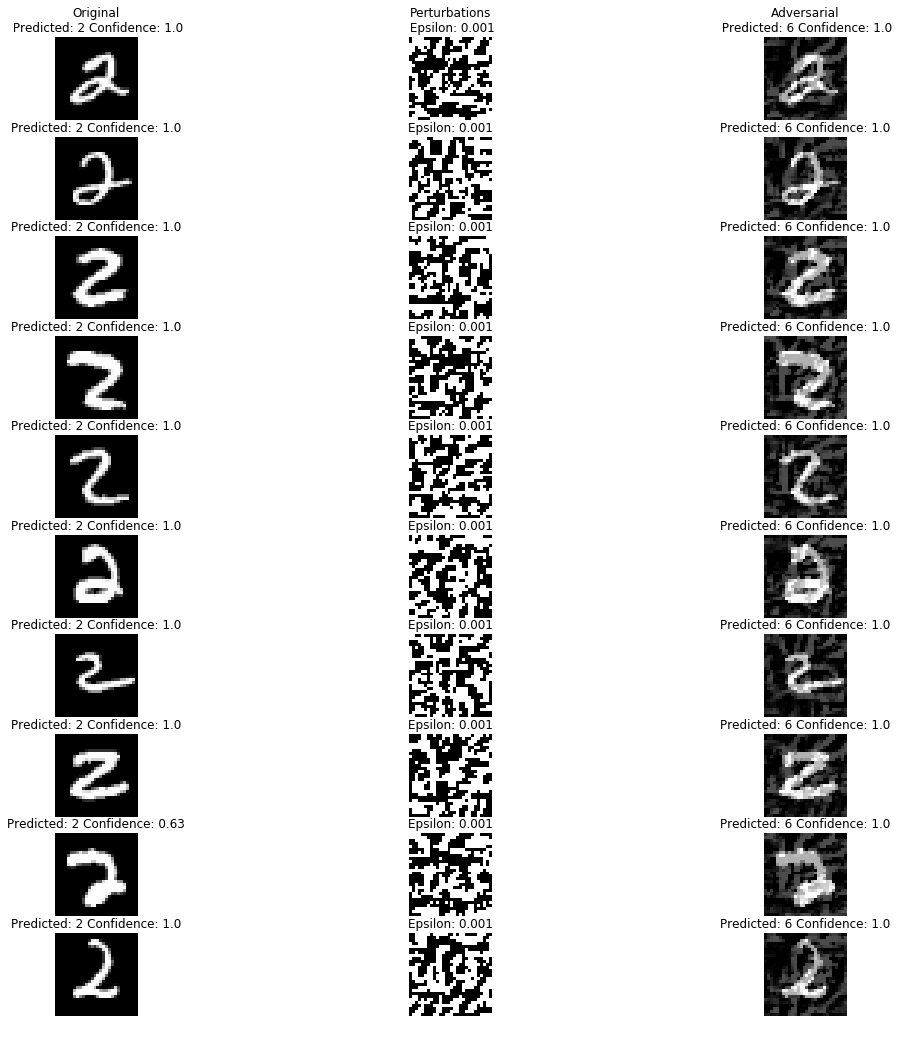

In [0]:
# Generate adversarial images from selected MNIST digits.
advs_fgsm, perturbs_fgsm = generate_fgsm(
    mnist_classifier.network, mnist_twos, target=6, epsilon=0.001, epochs=300)

# Making prediction for adversarial images generated by FGSM.
preds_fgsm, probs_fgsm = mnist_classifier.predict(advs_fgsm, logits = True)

# Convert predictions and probabilities into lists.
preds_fgsm = preds_fgsm.tolist()
probs_fgsm = np.max(probs_fgsm,axis=1).tolist()

# Plot the original image, perturbations and adversarial
# inputs with model predictions and confidence.
plot_adversarials(mnist_twos, perturbs_fgsm, advs_fgsm, 
                  orig_preds, orig_probs, probs_fgsm, preds_fgsm, eps=0.001)

There are two notable observations here:

1. Inputs were successfully manipulated to be misclassified as 6. The success rate of iterative FGSM attack is high.
2. FGSM technique is designed to produce pertubations along many dimensions, which might make them detectable to even human eyes. There are other white box methods that produce adversarial inputs by only modifying limited number of dimensions.

## Jacobian Based Saliency Map Attack

JSMA is another gradient based whitebox method. Papernot et al. (2016)[4] proposed to use the gradient of loss with each class labels with respect to every component of the input i.e. jacobian matrix to extract the sensitivity direction. Then a saliency map is used to select the dimension which produces the maximum error using the following equation:

$$S(x, t)[i]=\left\{\begin{array}{ll}{0,} & {\text { if } \frac{\partial F_{t}}{\partial x_{i}}(x)<0 \text { or } \sum_{j \neq t} \frac{\partial F_{j}}{\partial x_{i}}(x)>0} \\ {\frac{\partial F_{t}}{\partial x_{i}}(x)\left|\sum_{j \neq t} \frac{\partial F_{j}}{\partial x_{i}}(x)\right|,} & {\text { otherwise }}\end{array}\right.$$

Let's again try to create adversarial inputs that will fool our network to classify digit 2 as 6, but this time with as little perturbations as possible.

In [0]:
def saliency_map(X, dtdx, dodx, eps, cmin, cmax):
  """
  Saliency map function that returns score for each input dimension.
  """
  # Check initial conditions.
  c1 = tf.logical_or(eps < 0, X < cmax)
  c2 = tf.logical_or(eps > 0, X > cmin)
  
  # Check saliency map conditions.
  c3 = dtdx >= 0
  c4 = dodx <= 0
  
  # Get 1D score by doing logical AND between conditions.
  cond = tf.cast(tf.reduce_all([c1, c2, c3, c4], axis=0),dtype=tf.float32)
  
  score = cond * (dtdx * tf.abs(dodx))
  
  # Return score for each pixel
  score = tf.reshape(score, shape=[1, 784])
  
  return score

In [0]:
def jacobian_matrix(y, x, n_class):
  """
  Calculate jacobian of logits wrt input.
  """
  for i in range(n_class):
      if i==0:
          j = tf.gradients(y[i], x)
      else:
          j = tf.concat([j, tf.gradients(y[i], x)],axis=0)
  return j

In [0]:
def jsma(X_adv, target_y, model, eps, cmin=0.0, cmax=1.0):
  """
  Implementation of JSMA method to generate adversarial images.
  """
  # Get model logits and probs for the input.
  logits, probs = model(tf.reshape(X_adv, shape=(-1,28,28,1)))
  
  # Get model prediction for inputs.
  y_ind = tf.argmax(probs[0])
  
  # Calculate jacobian matrix of logits wrt to input.
  jacobian = jacobian_matrix(tf.reshape(logits, (-1,)), X_adv, 10)

  # Get the gradient of logits wrt to prediction and target.
  grad_input, grad_target = jacobian[y_ind], jacobian[target_y]
  grad_other = grad_input - grad_target
  
  # Compute saliency score for each dimension.
  score = saliency_map(X_adv, grad_target, grad_other, eps, cmin, cmax)

  # Select dimension of input and apply epsilon value.
  idx = tf.argmax(score, axis=1)
  pert = tf.one_hot(idx, 784, on_value=eps, off_value=0.0)
  pert = tf.reshape(pert, shape=tf.shape(X_adv))

  X_adv = tf.clip_by_value(X_adv + pert, cmin, cmax)

  return X_adv, pert

In [0]:
def generate_jsma(model, X, target, eps=1.0, epochs=50):
  """
  Run JSMA on input image for `epochs` number of times.
  """
  tf.reset_default_graph()
  tf.set_random_seed(42)
  
  # Placeholder for single image.
  X_p = tf.placeholder(shape=[28, 28, 1], dtype=tf.float32)
  
  # Op for one iteration of jsma.
  adv_op = jsma(X_p, target_y=target, model=model, eps=eps)

  digit = X.reshape(28,28,1)

  with tf.Session() as sess:
    tf.train.Saver().restore(sess, "model.ckpt")
    for i in range(epochs):
      
      digit, pert_iter = sess.run(adv_op, {X_p: digit})
      
  pert = digit - X
      
  return digit.reshape(28,28), pert.reshape(28,28)

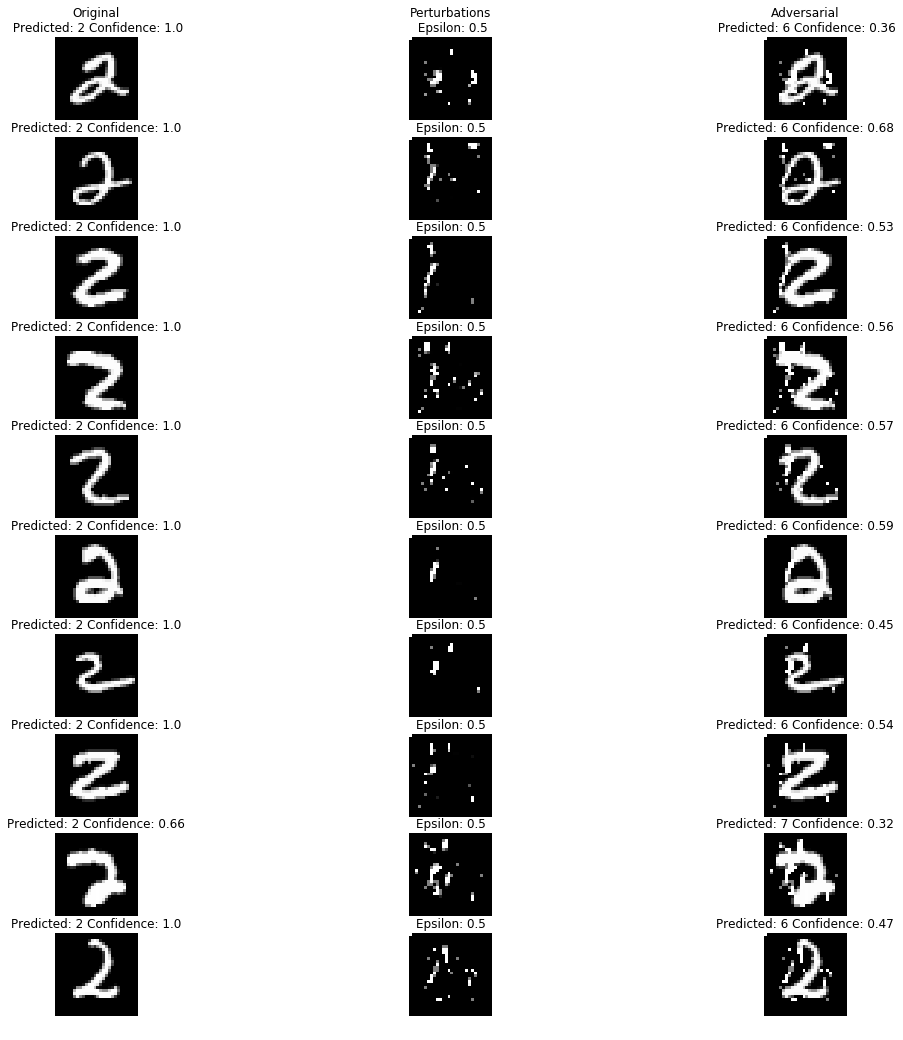

In [0]:
# Generate adversarial image and pertubations using JSMA method.
advs_jsma, perts_jsma = [], []
for imgs in mnist_twos:
  digit,pert = generate_jsma(mnist_classifier.network,
                        imgs,
                        target=6,
                        eps=0.5,
                        epochs=100)
  advs_jsma.append(digit)
  perts_jsma.append(pert)

# Get predictions and confidence for adversarial inputs
preds_jsma, probs_jsma = mnist_classifier.predict(
    np.array(advs_jsma).reshape(10,28,28,1), logits=True)

# Convert predictions and probabilities into lists.
preds_jsma = preds_jsma.tolist()
probs_jsma = np.max(probs_jsma, axis=1).tolist()

# Plot the result.
plot_adversarials(mnist_twos, np.array(perts_jsma), np.array(advs_jsma), 
                  orig_preds, orig_probs, probs_jsma, preds_jsma, eps=0.5)

The two notable observations here are:

1. The major distinction of JSMA with FGSM is that it reduces the number of perturbations, making the adversarial examples far less detectable. But this comes at an expense of a higher computation cost.
2. JSMA is useful for targeted misclassification attacks [2]. This is indeed observed by high success rate of misclassifying 2 as 6 in the experiment.

## Extreme Blackbox Attack: One Pixel Attack

White-box attacks use gradient information of the neural networks which may not be able to an adversary in the real world situation. However, several black box attacks like surrogate models etc have shown to be quite effective in fooling networks. One of the extreme methods that demonstrates the severity of adversarial attacks is One Pixel Attack proposed  by J. Su et al (2017)[5].  They successfully cause networks to misclassify labels by only modifying one pixel (the RGB values) using an evolutionary algorithm called Differential Evolution on CIFAR-10 and ImageNet datasets.

Differential evolution by R. Storn and K. Price (1997) is a simple evolutionary algorithm that works very well for optimization of complex functions where gradient based optimization cannot be used. It differs from other popular genetic algorithms by representing individuals as a vector of real numbers instead of chromosonal representations (binary, etc.) which makes them suitable to numerical optimization. New individuals are generated as 

$$X_c = X_{p_1} + mutation*(X_{p_2} - X_{p_3})$$

We will be using a modified Scikit learn's differential evolution implementation which is GPU optimized. [Source](https://raw.githubusercontent.com/Hyperparticle/one-pixel-attack-keras/master/differential_evolution.py) 

In [0]:
!wget https://raw.githubusercontent.com/Hyperparticle/one-pixel-attack-keras/master/differential_evolution.py
import differential_evolution

--2019-07-05 06:21:49--  https://raw.githubusercontent.com/Hyperparticle/one-pixel-attack-keras/master/differential_evolution.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38538 (38K) [text/plain]
Saving to: ‘differential_evolution.py’

differential_evolut 100%[===================>]  37.63K  --.-KB/s    in 0.01s   

2019-07-05 06:21:49 (3.06 MB/s) - ‘differential_evolution.py’ saved [38538/38538]



Before we can begin, we need to define a few auxilliary functions. Reference implementation: https://github.com/Hyperparticle/one-pixel-attack-keras

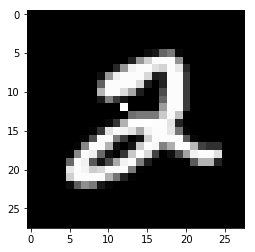

In [0]:
def perturb(xs, img):
  """
  Perturb (x,y) position of img with value z.
  Params
  ------
  xs: np.array
    Array of 3-tuple (x,y,z).
  img: np.array
    array of images to be perturbed.
  """

  if xs.ndim < 2:
      xs = np.array([xs])

  # Copy the image.
  imgs_cp = np.copy(img)
  tile = [len(xs)] + [1]*(xs.ndim+1)
  imgs_cp = np.tile(imgs_cp, tile)

  for x,img in zip(xs, imgs_cp):
    
    # Split the array into size 3 of (x,y,z).
    pixels = np.split(x, len(x) // 3)
    # For each perturbation tuple, apply the perturbation.
      for pixel in pixels:
        pixel = pixel.astype(int)
        img[pixel[0], pixel[1]] = pixel[2]/256.

  return imgs_cp

# Testing the perturb function.
im = perturb(np.array([[12.1,12,256],[3,3,256],[3,23,256]]),mnist_twos[:3])
plt.imshow(im[0].reshape(28,28),cmap='gray')
plt.show()

In [0]:
def predict(pixels, imgs, target_y, model):
  """
  Utility function required for DE which perturbs `imgs`
  with perturbation vector `pixels` and returns the confidence value
  for `target_y`. The goal of DE is to minimize the value returned by this
  function.
  """
  if len(imgs.shape) == 3:
    imgs = np.expand_dims(imgs, axis=0)
  pert_imgs = perturb(pixels, imgs)
  preds, probs = model.predict(pert_imgs, logits=True)
  target_probs = probs[:,target_y]
  return target_probs

predict(np.array([12,12,256,3,3,256,3,23,256]),mnist_twos[:3],2, mnist_classifier)

array([1.       , 1.       , 0.9999994], dtype=float32)

In [0]:
def success(pixel, img, target_y, model, targeted=True, verbose=False):
  """
  Utility function to let DE know if search is successful.
  Returns True when the prediction of the perturbed `img` is not
  `target_y` if `targetd` is False. Otherwise returns True only when
  model prediction is equal to `target_y`
  """
  if len(img.shape) == 3:
    img = np.expand_dims(img, axis=0)
  pert_img = perturb(pixel, img)
  pred, prob = model.predict(pert_img, logits=True)
  if verbose:
    print('Confidence: ' +str(np.round(prob[0],4)))
  
  if targeted:
    if pred == target_y:
      return True
  else:
    if pred != target_y:
      return True
  
  return None

success(np.array([12,12,256]), mnist_twos[2], 2, mnist_classifier, targeted=False, verbose=True)

Confidence: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


differential_evolution step 1: f(x)= 0.998858
differential_evolution step 2: f(x)= 0.998858
differential_evolution step 3: f(x)= 0.998858
differential_evolution step 4: f(x)= 0.998858
differential_evolution step 5: f(x)= 0.998858
differential_evolution step 6: f(x)= 0.997917
differential_evolution step 7: f(x)= 0.997917
differential_evolution step 8: f(x)= 0.997917
differential_evolution step 9: f(x)= 0.997917
differential_evolution step 10: f(x)= 0.997917
differential_evolution step 11: f(x)= 0.997917
differential_evolution step 12: f(x)= 0.997917
differential_evolution step 13: f(x)= 0.997917
differential_evolution step 14: f(x)= 0.997902
differential_evolution step 15: f(x)= 0.997902
differential_evolution step 16: f(x)= 0.997902
differential_evolution step 17: f(x)= 0.996761
differential_evolution step 18: f(x)= 0.996761
differential_evolution step 19: f(x)= 0.996761
differential_evolution step 20: f(x)= 0.996761
differential_evolution step 21: f(x)= 0.996761
differential_evolution

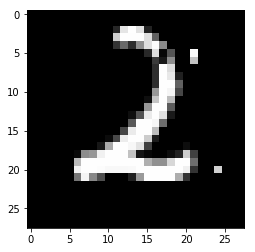

Final Model Prediction: 1 Confidence: [3.1611852e-14 5.1295781e-01 4.8704225e-01 1.3920888e-08 1.2572298e-16
 6.1546397e-15 3.6752604e-21 2.3093923e-17 4.8683776e-11 7.9276641e-20]
     fun: 0.48704225
 message: 'callback function requested stop early by returning True'
    nfev: 704295
     nit: 140
 success: False
       x: array([ 20.59666146,  24.48196485, 208.60757262,   5.67735888,
        17.5557184 ,   7.66748139,   5.90305368,  21.29968871,
       250.38335109,   6.82385811,  17.44072325,  24.56241858,
         6.22904297,  21.7012594 , 196.13033564])


In [0]:
def attack(img, target_y, model,maxiter=400, 
           popsize=5000, num_pixels=1, targeted=False):
  """
  Wrapper function for performing DE and showing the final result.
  """
  # Defining the range of values to be searched.
  bounds = [(0,28),(0,28),(0,256)] * num_pixels
  
  predict_fn = lambda pixels: predict(pixels, img, target_y, model)
  success_fn = lambda pixel, convergence: success(
      pixel, img, target_y, model, targeted)
  
  popmul = max(1, popsize // len(bounds))
  
  result = differential_evolution(predict_fn, bounds, callback=success_fn, 
                                  popsize=popmul,maxiter=maxiter,disp=True,
                                  polish=False, recombination=1, tol=-1,seed=7)
  
  final = perturb(result.x, img)
  
  pred,prob = model.predict(final.reshape(1,28,28,1),logits=True)
  
  plt.imshow(final.reshape(28,28), cmap='gray')
  plt.show()
  
  print('Final Model Prediction: {0} Confidence: {1}'.format(pred[0],prob[0]))
  print(result)
  return result, final.reshape(28,28)

result, adv = attack(mnist_twos[9], 2, model=mnist_classifier, num_pixels=5)

There are two notable observations here:

1. It is apparent that searching for successful one pixel perturbation is a difficult task for MNIST. This is because MNIST images are grayscale two dimensional images whose space where adversarial perturbations can be found is small  in comparision to 3D RGB input space of CIFAR-10 and ImageNet. Because of the exponential increase in input space, the probability of finding adversarial perturbation by search heuristics like evolutionary algorithm increases significantly. Even though finding one pixel perturbation failed, 5 pixel search was successful, suggesting larger search space indeed makes it easier to find adversarial examples.
2. The difficulty of attacks with small number pertubation and search space suggests that applying domain specific transformations of complex inputs to simpler inputs as a preprocessing step might be helpful in increasing difficulty of attacks.

# Analyzing effects of adversarial inputs

To analyze what is happening inside the neural networks with adversarial inputs, we can take two different perspective:

## Effect on the Representation space

Deep neural networks are composed of a series of transformation of the high dimensional input space to a low dimensional representation space. It is this representation space upon which a linear classifier is employed to create a decision boundary for classification task. We can attempt to visualize the representation space by reducing the dimensionality to two using algorithms like tSNE. 



Before we begin, lets Install **TSNECUDA**,  a GPU optimized TSNE library  (from Anaconda's package manager to avoid building from source)

In [0]:
# Instructions from https://stackoverflow.com/questions/49202649/how-to-build-libraries-via-conda-on-colab-research
!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y --prefix /usr/local tsnecuda cuda100 -c cannylab

import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')

--2019-07-04 17:30:05--  https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
installing: python-3.6.4-hc3d631a_1 ...
Python 3.6.4 :: Anaconda, Inc.
installing: ca-certificates-2017.08.26-h1d4fec5_0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: intel-openmp-2018.0.0-hc7b2577_8 ...
installing: libgcc-ng-7.2.0-h7cc24e2_2 ...
installing: libgfortran-ng-7.2.0-h9f7466a_2 ...
installing: libstdcxx-ng-7.2.0-h7a57d05_2 ...
installing: bzip2-1.0.6-h9a117a8_4 ...
installing: expat-2.2.5-he0dffb1_0 ...
installing: gmp-6.1.2-h6c8ec71_1 ...
installing: graphite2-1.3.10-hf63cedd_1 ...
installing: icu-58.2-h9c2bf20_1 ...
installing: jbig

To see the effect of the representation of the original input to adversarial input, lets plot their position in the representation space to observe the change from one class to another. If small perturbations push the representations slightly to cross the decision boundary, it can observed that in the visualization.

In [0]:
# Get the representations of our training data.
preds_x_train, z = mnist_classifier.predict(x_train, reps=True)

# Get the representation of selected Twos and their adversarial images.
twos_probs, twos_reps = mnist_classifier.predict(mnist_twos, reps=True)

advs_probs, advs_reps = mnist_classifier.predict(
    advs_fgsm.reshape(-1,28,28,1), reps=True)

# Concatenate the representations to perform dimensionality reduction together.
reps = np.append(z, twos_reps, axis=0)
reps = np.append(reps, advs_reps, axis=0)

# Import GPU optimized TSNE library and perform dimensionality reduction
# to 2 dimensional space for visualization.
from tsnecuda import TSNE
reps_tsne = TSNE(n_components=2).fit_transform(reps)

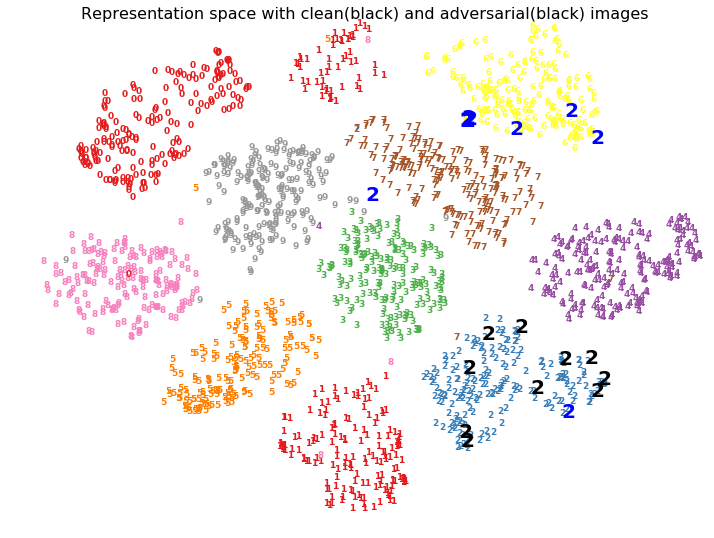

In [0]:
# Normalize the embeddings.
x_min, x_max = np.min(reps_tsne, 0), np.max(reps_tsne, 0)
X = (reps_tsne - x_min) / (x_max - x_min)
y = y_train
plt.figure(figsize=(12,9))
ax = plt.subplot(111)
ax.set_facecolor("white")
# Plot 2000 samples from training sets.
for i in range(2000):
  plt.text(X[i, 0], X[i, 1], str(y[i]),
             color=plt.cm.Set1(y[i] / 10.),
             fontdict={'weight': 'bold', 'size': 9})
# Plot clean and adversarial images.
for i in range(10):
  plt.text(X[60000+i, 0], X[60000+i, 1], 2,
           color='black',
           fontdict={'weight': 'bold', 'size': 20})
  plt.text(X[60010+i, 0], X[60010+i, 1], 2,
           color='blue',
           fontdict={'weight': 'bold', 'size': 20})
    
plt.axis('off')
plt.title('Representation space with clean(black) and adversarial(black) images', fontsize=16)
plt.show()

We can see in the tSNE plot that adversarial representations are jumping from the original cluster to targeted class's cluster. Since topological information of tSNE plots should be taken  with a grain of salt, lets also visualize the PCA embeddings of the representation space.

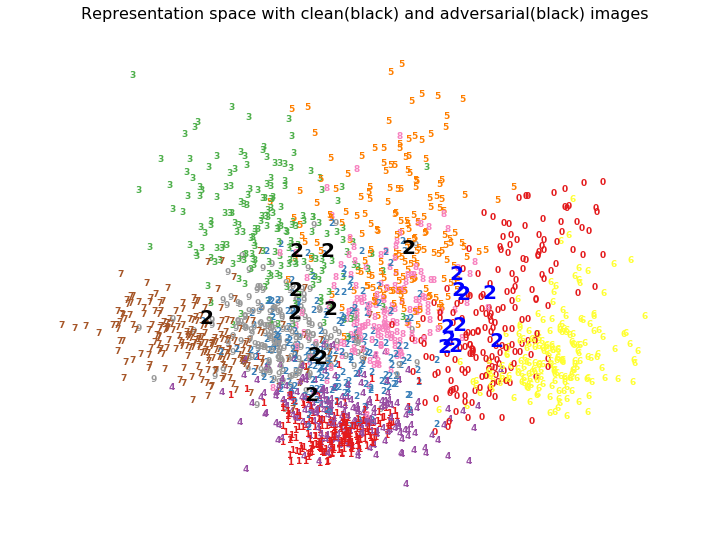

In [0]:
# Get PCA embedding of representation space.
from sklearn.decomposition import PCA
reps_pca = PCA(n_components=2).fit_transform(reps)

# Normalize the embeddings.
x_min, x_max = np.min(reps_pca, 0), np.max(reps_pca, 0)
X = (reps_pca - x_min) / (x_max - x_min)
y = y_train
plt.figure(figsize=(12,9))
ax = plt.subplot(111)
ax.set_facecolor("white")
# Plot 2000 samples from training sets.
for i in range(2000):
    plt.text(X[i, 0], X[i, 1], str(y[i]),
             color=plt.cm.Set1(y[i] / 10.),
             fontdict={'weight': 'bold', 'size': 9})
# Plot clean and adversarial images.
for i in range(10):
    plt.text(X[60000+i, 0], X[60000+i, 1], 2,
             color='black',
             fontdict={'weight': 'bold', 'size': 20})
    plt.text(X[60010+i, 0], X[60010+i, 1], 2,
             color='blue',
             fontdict={'weight': 'bold', 'size': 20})
    
plt.axis('off')
plt.title('Representation space with clean(black) and adversarial(black) images', fontsize=16)
plt.show()

The observations here are:

1. Since targeted attacks are able to change the classes to any specific intended class, it is clear that the adversarial representations are not just nudged into a neighboring cluster, but can be placed in arbitrary cluster because of which networks give incorrect predictions with high confidence.
2. Adversarial examples may not just affect the final representation space but also the earlier layers significantly which cause eventual misplacement of representations in incorrect cluster leading to high confidence incorrect misclassification.

## Effect on the Activation of the layers

To observe the behaviour of intermediate layers on adversarial inputs, lets visualize the differences of the activations of original input and the adversarial input of the CNN. For each convolutional layer, we subract the activations of two inputs along the kernels, and take the maximum of those differences to visualize the activation map.



In [0]:
def activations(model, origs, advs):
  
  tf.reset_default_graph()
  tf.set_random_seed(42)

  X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32)
  
  # Get the intermediate activations op.
  logits, activations = model(X, activations=True)

  with tf.Session() as sess:
      tf.train.Saver().restore(sess, "model.ckpt")
      
      _, actvs = sess.run([logits, activations], {X: origs})
      _, actvs_advs = sess.run([logits, activations], {X: advs})
  
  return actvs, actvs_advs 

In [0]:
def plot_activation_map(num_layers, origs,actvs, actvs_advs):
  
  f,ax = plt.subplots(origs.shape[0], num_layers+1,figsize=(16,16))
  plt.subplots_adjust(wspace=0.01, hspace=0.5)
  
  for img_idx in range(origs.shape[0]):
    
    ax[img_idx][0].imshow(origs[img_idx].reshape(28,28),cmap='gray')
    ax[img_idx][0].axis('off')
    ax[img_idx][0].set_title('Input')
    for i in range(num_layers):
      # For each layer, take maximum difference in the channel dimension.
      diff = np.max(actvs[i][img_idx] - actvs_advs[i][img_idx], axis=2)
      ax[img_idx][i+1].imshow(diff,cmap='gray')
      ax[img_idx][i+1].axis('off')
      ax[img_idx][i+1].set_title('ConvLayer {}'.format(i+1))
  
  plt.show()

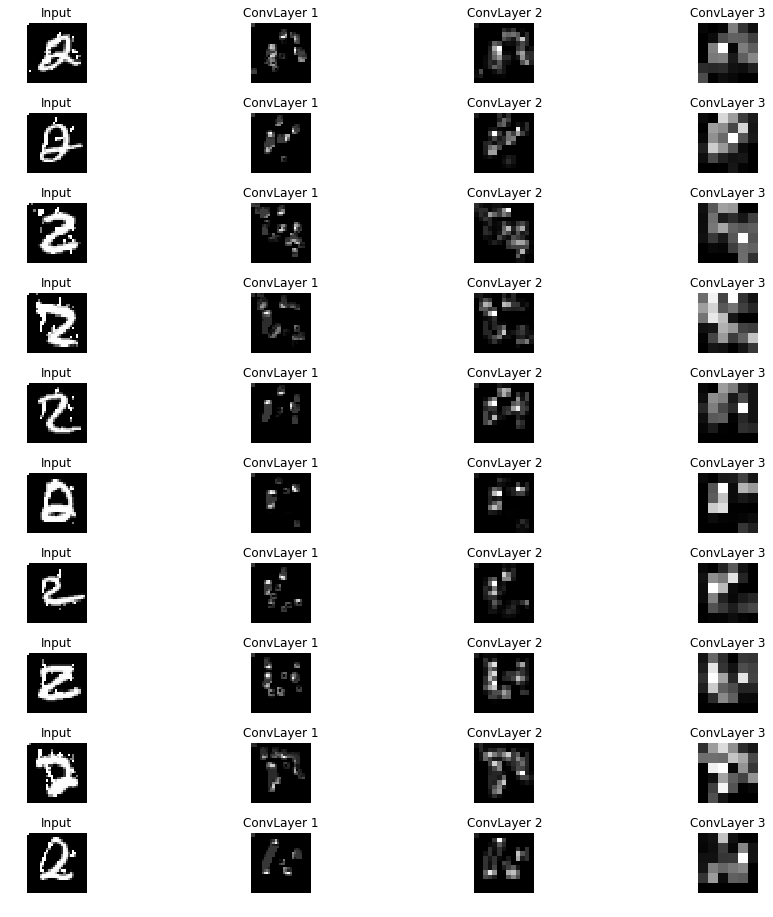

In [0]:
# Get the activations for clean and adversarial images.
actvs, actvs_advs = activations(mnist_classifier.network, mnist_twos, np.array(advs_jsma).reshape(-1,28,28,1))
# Plot the activation map of difference of the activations for Conv layers.
plot_activation_map(3, np.array(advs_jsma), actvs, actvs_advs)

The activations maps reveal how pertubations create an exploding effect of significant activation change through the layers. This exploding effect reaches the final layer and causes the representation of the adversarial example to be very different than the original input.

The observations are:

1. The exploding effect of activation by slight perturbation shows that the layers are not robust and very much dependant on the right input from the earlier layers. Perhaps if the layers were resilent to slight changes in activations, this effect would be moderated.
2. In some unsuccessful attacks, the activation difference tapers off through the layers and does not reach the final layer. This causes final representation to remain very close to the clean input's representation and thus misclassification is avoided.

# Defense Mechanisms

Minimizing adversarial vulnerability has recieved substantial amount of research input in recent years. Several proposed defense mechanisms in the literature can broadly be categorized as:

1. **Robustification**: This approach is concerned with making neural networks less succeptible to adversarial attacks by regularizing against them with specialized architecture or loss functions. Two popular mechanisms are:
    1. Adversarial Training [1]: It modifies the loss function to augment training data with peturbed samples using FGSM technique during training. 
    2. Defensive Distillation [6]: It is another popular approach in which a model is first trained normally with training dataset to output class probabilities. Then another identical model is trained using these probabilities as soft labels instead of class labels. This has the effect of smoothing the loss function and increasing the generalization leading to higher accuracy for adversarial examples. 

    Developing robustification schemes is challenging, especially due to strong transferrability of adversarial samples which allows black box attacks to bypass these defenses.  Lack of strong theoritical models of adversarial attack is the major limitation in developing robustification defenses.

2. **Detection**: Detection mechanisms take a different route by predicting if an input contains adversarial pretubations, instead of modifying the classification model. Defense mechanisms range from classifying adversarial attacks as a separate class [7] to using generative models to reconstruct adversarial inputs into clean images [8,9]. The advantage of detection mechanisms is that they can be brought in as the first line of defense in practical settings without disturbing the main model. MagNet[8] and DefenseGAN[9] are recent examples along this approach and have produced great results, but the worry is these defenses still might be vulnerable if attackers have the knowledge of mechanism being used.

### Using Autoencoders to prevent adversarial inputs

In this section, let's try to create a detection based defense mechanism that can identify apriori if the input contains adversarial perturbations. The idea is to protect the classifier from any input that does not belong to the data distribution it has not been trained on. 

It has been shown that autoencoders are very good at capturing data distribution. They can reconstruct inputs with very low error if their input belongs to the training data distribution. This fact can be exploited to check if the input (adversarial or clean) belongs to the distribution that the classification model understands. When an adversarial input is  fed to the encoder, it produces incorrect representation. This representation is then fed to the decoder, which generates sample from incorrect class . If there is statistical mismatch between the adversarial input and its generated output, it can be implied that input does not belong to training data distribution and was intended to fool the classification model. Here, we use Variational Autoencoder ([Reference Implementation](https://keras.io/examples/variational_autoencoder_deconv/) from official Keras website) , owing to their smooth latent representation space which helps avoid degenrate reconstruction.

In [0]:
# Example adopted from https://keras.io/examples/variational_autoencoder_deconv/
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

def sampling(args):

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# network parameters
image_size = 28
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

models = (encoder, decoder)
reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                              K.flatten(outputs))

# KL Divergence loss
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 11s 189us/step - loss: 194.3626 - val_loss: 174.2476
Epoch 2/30
60000/60000 [==============================] - 10s 174us/step - loss: 170.3455 - val_loss: 166.5233
Epoch 3/30
60000/60000 [==============================] - 10s 173us/step - loss: 163.6147 - val_loss: 161.6736
Epoch 4/30
60000/60000 [==============================] - 10s 174us/step - loss: 159.9754 - val_loss: 158.5716
Epoch 5/30
60000/60000 [==============================] - 10s 173us/step - loss: 157.6579 - val_loss: 156.5680
Epoch 6/30
60000/60000 [==============================] - 10s 173us/step - loss: 155.9916 - val_loss: 155.5772
Epoch 7/30
60000/60000 [==============================] - 10s 174us/step - loss: 154.6586 - val_loss: 153.7337
Epoch 8/30
60000/60000 [==============================] - 10s 174us/step - loss: 153.5092 - val_loss: 153.3261
Epoch 9/30
60000/60000 [==============================] - 11s 

The following are the adversarial inputs and their corresponding generated images by VAE (bottlenect latent dimension is 2.

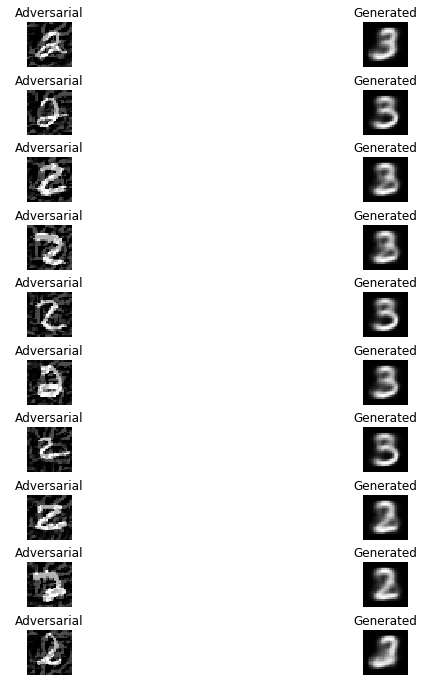

In [0]:
# Generate images by passing adversarian samples to VAE.

zs = encoder.predict(advs_fgsm.reshape(-1,28,28,1))
X_gen = decoder.predict(zs[2])

# Plot the adversarial input and the generated input.
f,ax = plt.subplots(10,2,figsize=(12,12))
plt.subplots_adjust(wspace=0.01, hspace=0.5)

for img_idx in range(0,10):
  
  ax[img_idx][0].imshow(advs_fgsm[img_idx].reshape(28,28),cmap='gray')
  ax[img_idx][0].axis('off')
  ax[img_idx][0].set_title('Adversarial')
  
  ax[img_idx][1].imshow(X_gen[img_idx].reshape(28,28),cmap='gray')
  ax[img_idx][1].axis('off')
  ax[img_idx][1].set_title('Generated')

The accuracy of the classifier on adversarial inputs in 9.5%, whereas on the generated input, it is 16.4%. The low accuracy is to be expected as we want the VAE to fooled by the adversarial input so that it generates incorrect outputs.

In [0]:
# Generate adversarial images from MNIST testset.
advs_fgsm_test, perturbs_fgsm = generate_fgsm(
    mnist_classifier.network, x_test, target=6, epsilon=0.001, epochs=300)

# Generate images from above adversarial inputs.
zs = encoder.predict(advs_fgsm_test.reshape(-1,28,28,1))
X_gen = decoder.predict(zs[2])

# Predict accuracy on adversarial test_digits.
preds_adv, probs_adv = mnist_classifier.predict(advs_fgsm_test.reshape(-1,28,28,1), logits=True)
acc_adv = mnist_classifier.metrics(y_test_oh, probs_adv, verbose=False)
print('Accuracy on adversarial inputs: ',acc_adv)

# Predict accuracy on adversarial test_digits after passing through cae.
preds_gen, probs_gen = mnist_classifier.predict(X_gen.reshape(-1,28,28,1), logits=True)
acc_gen = mnist_classifier.metrics(y_test_oh, probs_gen, verbose=False)
print('Accuracy on generated inputs: ',acc_gen)

Accuracy on adversarial inputs:  0.0959
Accuracy on generated inputs:  0.1638


Lets plot the distribution of KL divergence between adversarial and generated input AND clean and generated output to see if there is statistical mismatch. By selecting a threshold from the distribution plots, we can also calculate the success rate of detection.

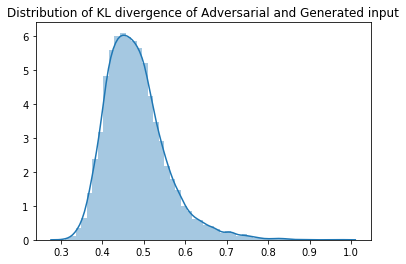

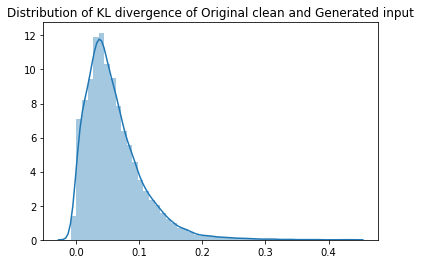

Success rate of detection:  1.0


In [0]:
import seaborn as sns

def KL(p, q, eps = 1e-05):
  p +=eps
  q +=eps 
  return np.mean(p*np.log(p/q),axis=1)

kl_advs = KL(advs_fgsm_test.reshape(-1,784), X_gen.reshape(-1,784))

sns.distplot(kl_advs).set_title('Distribution of KL divergence of Adversarial and Generated input')
plt.show()

# Generate images from adversarial inputs.
zs = encoder.predict(x_test.reshape(-1,28,28,1))
X_test_gen = decoder.predict(zs[2])

kl_clean = KL(x_test.reshape(-1,784), X_test_gen.reshape(-1,784))

sns.distplot(kl_clean).set_title('Distribution of KL divergence of Original clean and Generated input')
plt.show()

# We can see a clear distinction around value 0.3 from the graphs.
# Now lets see if we can identify adversarial images.
success = (kl_advs > 0.3).sum()/x_test.shape[0]
print('Success rate of detection: ',success)

The plots demonstrate that KL divergence between the clean or adversarial input and their generated outputs. The KL divergence between clean and their corresponding generated sample is distributed from 0 to 0.3. Similarly KL divergence between clean and corresponding adversarial sample is distributed from 0.3 to 1.0. This clear distinction between the range of values of KL divergence for clean and adversarial inputs suggest that this method can be used to detect adversarial inputs.

Using the threshold of 0.3 we achieve 99% to 100% success rate for detection. The initial results on MNIST, a benchmark dataset, are very impressive. However  the method needs more rigorous treatment with wide range of adversarial attack generation techniques and datasets to ascertain its generalizability. 

### Other potential ideas

The following are other directions of research for adversarial defense (from my limited exposure to the research and literature in this field) which might be worth exploring:

1. RBF Networks are somewhat immune to adversarial samples because of their nonlinear nature [10]. If their generalizability can be improved to the current levels neural networks, they can be used as detector networks to support the decision of the main model. If the prediction label and confidence between these networks have high mismatch, the input might be adversarial.
2. Adversarial attacks are considered spectacular failures because we expect the outcome state of the art models to align to human expectations. But it is apparent that they use other signals which are imperceptible to us humans to make their predictions. In the domains like computer vision, text and audio, we can regularize the classification networks explicitly to use human perceptible semantic priors like shapes and appearance instead of imperceptible signals. One possible method could be to disentangle and identify the generative factors that are being used by the model and compare to see if they align with such human priors.

# Conclusion

Despite impressive accomplishments of deep neural networks in recent years, adversarial examples are stark examples of their brittleness and vulnerability. Understanding their root cause and developing robust defense mechanisms is a very important area of research.

We have to remember that models are approximations and will always look for shortcuts unless explicitly instructed not to. Just because the end result matches our expectations does not necessarily mean the models have captured the same ideas and concepts as we humans have.

In this view, adversarial attacks are not unfortunate occurrences. Instead they should be taken as a rare insight into how models actually see and synthesize our world. Their very existence calls for more theoretical study of deep learning instead of just running after empirical results.

# References

[1] Szegedy, Christian, et al. "Intriguing properties of neural networks." arXiv preprint arXiv:1312.6199 (2013).

[2] A. Chakraborty, M. Alam, V. Dey, A. Chattopadhyay, and D. Mukhopadhyay, “Adversarial Attacks and Defences: A Survey,” vol. x, no. x, 2018.

[3] I. J. Goodfellow, J. Shlens, and C. Szegedy, “Explaining and Harnessing Adversarial Examples,” pp. 1–11, 2014.

[4] Papernot, Nicolas, et al. "The limitations of deep learning in adversarial settings." 2016 IEEE European Symposium on Security and Privacy (EuroS&P). IEEE, 2016.

[5] J. Su, D. V. Vargas, and S. Kouichi, “One pixel attack for fooling deep neural networks,” pp. 1–15, 2017.

[6] Hinton, G., Vinyals, O., & Dean, J. (2015). "Distilling the knowledge in a neural network." arXiv preprint arXiv:1503.02531.

[7] Hosseini, H., Chen, Y., Kannan, S., Zhang, B., & Poovendran, R. (2017). "Blocking transferability of adversarial examples in black-box learning systems." arXiv preprint arXiv:1703.04318.

[8] D. Meng and H. Chen, “MagNet: a Two-Pronged Defense against Adversarial Examples,” 2017.

[9] [1] P. Samangouei, M. Kabkab, and R. Chellappa, “Defense-GAN: Protecting Classifiers Against Adversarial Attacks Using Generative Models,” no. 3, 2018.

[10] Vidnerová, P., & Neruda, R. (2018, June). Deep networks with rbf layers to prevent adversarial examples. In International Conference on Artificial Intelligence and Soft Computing (pp. 257-266). Springer, Cham.
